# Sentiment Analysis on Amazon Fine Food Reviews 

**Approach:**
1. Preprocessing 
2. Creating a BERT model from the Tensorflow HUB.
3. Tokenization
4. Getting the pretrained embedding Vector for a given review from the BERT.
5. Using the embedding data apply NN and classify the reviews.
6. Creating a Data pipeline for BERT Model. 

## Loading Data

In [ ]:
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:04<00:00, 67.7MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 28.9MB/s]


In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<pre><font size=6>1.Preprocessing</font></pre>

In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
#get only 2 columns - Text, Score
#drop the NAN values (if any)
reviews = reviews.loc[:, ['Text', 'Score']]

In [ ]:
reviews.isnull().sum()

Text     0
Score    0
dtype: int64

In [ ]:
reviews['Score'].unique()

array([5, 1, 4, 2, 3])

In [ ]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows. 

reviews = reviews[reviews['Score']!=3]
bin_scores = [1 if (score>3) else 0 for score in list(reviews['Score'])]
reviews['Score'] = bin_scores

In [ ]:
reviews.shape

(525814, 2)

In [ ]:
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [ ]:
reviews['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [ ]:
reviews['Score'].value_counts()

1    87004
0    12996
Name: Score, dtype: int64

In [ ]:
import re
#testing re pattern to capture html tags in text column
s = " ".join(list(reviews["Text"]))
#refer - https://stackoverflow.com/questions/3075130/what-is-the-difference-between-and-regular-expressions
ls = re.findall('<.*?>', s)
print(len(np.unique(ls)))
print(ls[:3])

545
['<br />', '<br />', '<a href="http://www.amazon.com/gp/product/B001VIY9KW">']


In [ ]:
#remove the HTML tags from each text
#split the text using whitespace as separator(default), then join again to ensure the words are evenly spaced
reviews['Text'] = reviews['Text'].apply(lambda x: " ".join(re.sub('<.*?>', '', x).split()))

In [ ]:
#print head 5
reviews.reset_index(drop=True, inplace=True)
reviews.head()

,Text,Score,len
0,The tea was of great quality and it tasted lik...,1,30
1,My cat loves this. The pellets are nice and sm...,1,31
2,Great product. Does not completely get rid of ...,1,41
3,This gum is my favorite! I would advise everyo...,1,27
4,I also found out about this product because of...,1,22


In [ ]:
#check if any HTML tags are still present in Text column
s = " ".join(list(reviews["Text"]))
ls = re.findall('<.*?>', s)
print(len(np.unique(ls)))

0


In [ ]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

In [ ]:
reviews = pd.read_csv('preprocessed.csv')

In [ ]:
reviews.head()

,Text,Score,len
0,The tea was of great quality and it tasted lik...,1,30
1,My cat loves this. The pellets are nice and sm...,1,31
2,Great product. Does not completely get rid of ...,1,41
3,This gum is my favorite! I would advise everyo...,1,27
4,I also found out about this product because of...,1,22


In [ ]:
X = reviews['Text']
y = reviews['Score']

In [ ]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)

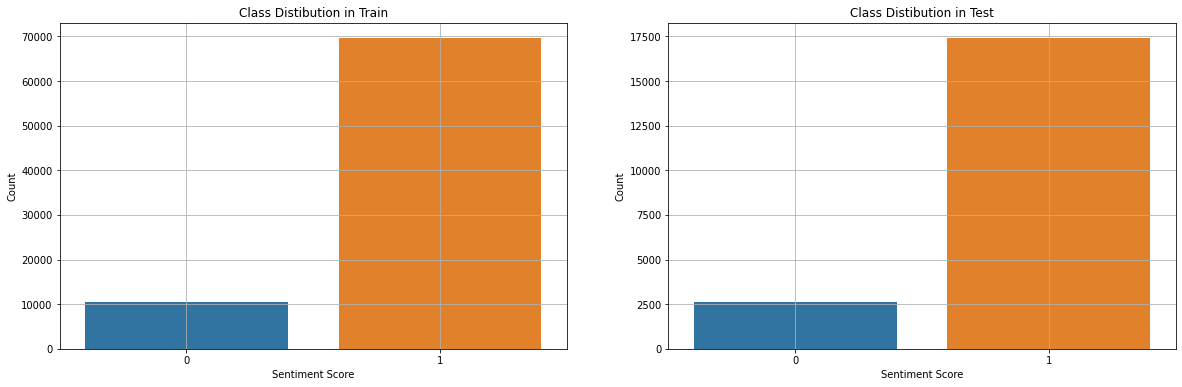

In [ ]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(20, 6))

plt.subplot(1,2,1)
ax_1 = sns.countplot(x = y_train)
ax_1.set(xlabel = 'Sentiment Score', ylabel = 'Count', title = 'Class Distibution in Train')
ax_1.grid()

plt.subplot(1,2,2)
ax_2 = sns.countplot(x = y_test)
ax_2.set(xlabel = 'Sentiment Score', ylabel = 'Count', title = 'Class Distibution in Test')
ax_2.grid()

plt.show()

<pre><font size=6>2.Creating BERT Model</font> 

To know more about BERT, refer <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this problem, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. you may change after percentile analysis 
max_seq_length = 55 

#BERT takes 3 inputs
#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#refer - https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>3.Tokenization</font></pre>

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 28.9 MB/s 


In [ ]:
import tokenization  #tokenization.py file

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
#[CLS], [SEP] and [PAD] are all present in vocab 
'[CLS]' in tokenizer.vocab.keys()

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [ ]:
def tokenizer_ops(text):
    tokens = tokenizer.tokenize(text)
    
    if len(tokens)<=(max_seq_length-2):
        tokens = ['[CLS]', *tokens, '[SEP]']
    else:
        tokens = tokens[0:(max_seq_length-2)]
        tokens = ['[CLS]', *tokens, '[SEP]']
    
    masked_arr = np.array([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))

    segment_arr = np.array([0]*max_seq_length)
    
    #we can add [PAD] tokens at the end till max_seq_length is acheived [([PAD] : 0) in vocab]
    #or we can convert tokens to ids and then add 0s at the end till max_seq_length is achieved
    #here we go with the former approach
    if len(tokens)<max_seq_length:
        diff = max_seq_length-len(tokens)
        tokens = tokens+['[PAD]']*diff
    
    token_ids_arr = np.array(tokenizer.convert_tokens_to_ids(tokens))
    
    return token_ids_arr, masked_arr, segment_arr

In [ ]:
X_train_arr = np.array(list(map(lambda x: tokenizer_ops(x), X_train.values)))
X_test_arr =  np.array(list(map(lambda x: tokenizer_ops(x), X_test.values)))

In [ ]:
X_train_tokens = X_train_arr[:,0,:]
X_train_mask = X_train_arr[:,1,:]
X_train_segment = X_train_arr[:,2,:]

X_test_tokens = X_test_arr[:,0,:]
X_test_mask = X_test_arr[:,1,:]
X_test_segment = X_test_arr[:,2,:]

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
import pickle

In [ ]:
# save all results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
# load from disk
X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<pre><font size=6>4.Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output = bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [ ]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [ ]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
# X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<pre><font size=6>5.Training a NN with 768 features</font>

Create a NN and train the NN. 
1. Using AUC as metric. We don't tf.keras.metrics.AUC because that calculates AUC batch wise and then averages all over which is not the right way , AUC must be calculated at end of epoch. 
We write custom code for AUC and print it at the end of each epoch
2. Using a basic NN architecture. 
3. Using tensorboard to log all metrics and losses.
4. Print the loss and metric at every epoch. 
5. Make sure model doesn't overfit or underfit. 
</pre>

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback

In [ ]:
#class weight 
class_w_dict = {}
num_samples = len(y_train)
num_classes = 2
samples_per_class = np.bincount(y_train)
for i in range(2):
    class_w_dict[i] = num_samples/(num_classes*samples_per_class[i])

In [ ]:
#custom AUC metric
from sklearn.metrics import roc_auc_score
def auc_roc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.float32)

In [ ]:
import os 
import datetime

In [ ]:
#writing callbacks
path = f'checkpoints' + '/weights-{epoch:02d}-{val_auc_roc:.4f}.hdf5'
checkpoint_cb= callbacks.ModelCheckpoint(filepath = path, monitor = 'val_auc_roc', 
                                                save_best_only=True, verbose=0, mode='max')
    
earlystop_callback = callbacks.EarlyStopping(monitor='val_auc_roc', min_delta=0.0001, 
                                                   patience=20, verbose=1, mode='max', restore_best_weights=True)

reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_auc_roc', patience = 3, factor = 0.6, mode='max', min_delta = 0.0001, min_lr=1e-7)

log_dir = os.path.join(f'logs','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

callback_list = [checkpoint_cb, earlystop_callback, tensorboard_cb, reduce_lr_cb]

In [ ]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Model

In [ ]:
#building the model architecture
tf.keras.backend.clear_session()

input_layer=Input(shape=(X_train_pooled_output.shape[1],))

dense_1 = Dense(512, activation='relu', kernel_initializer='he_normal')(input_layer)
dropout_1 = Dropout(0.4)(dense_1)

dense_2 = Dense(512, activation='relu', kernel_initializer='he_normal')(dropout_1)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(1024, activation='relu', kernel_initializer='he_normal')(dropout_2)
dropout_3 = Dropout(0.4)(dense_3)

dense_4 = Dense(1024, activation='relu', kernel_initializer='he_normal')(dropout_3)
dropout_4 = Dropout(0.4)(dense_4)

dense_5 = Dense(2048, activation='relu', kernel_initializer='he_normal')(dropout_4)
dropout_5 = Dropout(0.5)(dense_5)

dense_6 = Dense(2048, activation='relu', kernel_initializer='he_normal')(dropout_5)
dropout_6 = Dropout(0.5)(dense_6)

output_layer = Dense(1, activation='sigmoid')(dropout_5)

model = Model(inputs = input_layer, outputs = output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0     

In [ ]:
#training the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', auc_roc])
history = model.fit(x = X_train_pooled_output, y = y_train, validation_data=[X_test_pooled_output, y_test], class_weight = class_w_dict, epochs = 100, batch_size = 512, verbose=2, callbacks=callback_list)

Epoch 1/100
157/157 - 3s - loss: 0.7059 - accuracy: 0.6366 - auc_roc: 0.7050 - val_loss: 0.5556 - val_accuracy: 0.7225 - val_auc_roc: 0.9072 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 2/100
157/157 - 3s - loss: 0.4619 - accuracy: 0.7402 - auc_roc: 0.8680 - val_loss: 0.2584 - val_accuracy: 0.9028 - val_auc_roc: 0.9309 - lr: 0.0010 - 3s/epoch - 17ms/step
Epoch 3/100
157/157 - 2s - loss: 0.5076 - accuracy: 0.6652 - auc_roc: 0.8133 - val_loss: 0.3681 - val_accuracy: 0.8408 - val_auc_roc: 0.9323 - lr: 0.0010 - 2s/epoch - 16ms/step
Epoch 4/100
157/157 - 2s - loss: 0.4849 - accuracy: 0.6902 - auc_roc: 0.8273 - val_loss: 0.3950 - val_accuracy: 0.9126 - val_auc_roc: 0.9330 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 5/100
157/157 - 2s - loss: 0.4865 - accuracy: 0.6992 - auc_roc: 0.8275 - val_loss: 0.2824 - val_accuracy: 0.8939 - val_auc_roc: 0.9404 - lr: 0.0010 - 2s/epoch - 14ms/step
Epoch 6/100
157/157 - 2s - loss: 0.4748 - accuracy: 0.7305 - auc_roc: 0.8306 - val_loss: 0.3323 - val_accuracy: 0.9

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
results = pd.DataFrame(history.history)
results.sort_values(by = 'val_auc_roc', axis=0, ascending=False, inplace=True)

In [ ]:
results.head()

,loss,accuracy,auc_roc,val_loss,val_accuracy,val_auc_roc,lr
66,0.432277,0.682275,0.853434,0.270366,0.89510,0.955501,0.000028
56,0.430207,0.749713,0.853662,0.263441,0.90385,0.955496,0.000130
52,0.433495,0.712062,0.852616,0.263442,0.88185,0.955460,0.000216
59,0.431399,0.768313,0.854221,0.264952,0.91210,0.955457,0.000078
57,0.429688,0.766388,0.857228,0.274765,0.89910,0.955387,0.000130


Note: 

- Blue represents Validation Curve

- Orange represents Train Curve

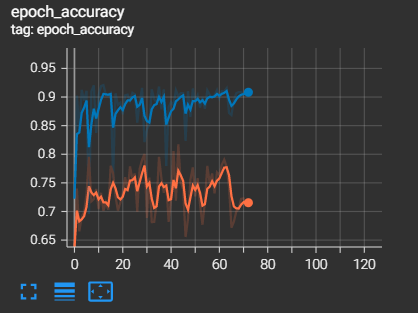

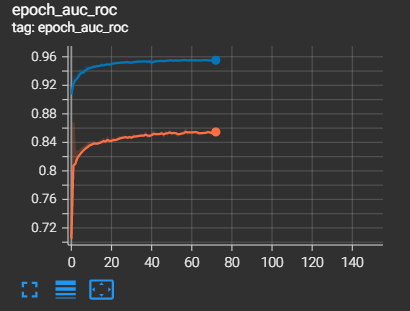

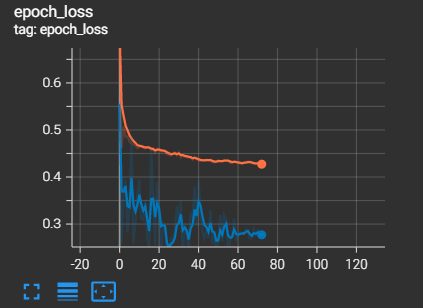

Observations: 

Note: We are referencing first epoch as 0th, second as 1st, and so on.

- Use of Dropout sets a portion of features to 0 during training however during testing all the features are used which leads to better performance on Test set compared to Train set. Hence, the difference can be observed in above performance graphs. *refer - https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy*

- Train Accuracy and Test Accuracy are fluctuating but follow an increasing fashion overall.

- Train AUC and Test AUC monotonically increase with each epoch.

- Train Loss continues to decrease every epoch while Test Loss is fluctuating but follows a decreasing fashion overall. 

- Overall Best Model is achieved at 66th Epoch with performance on Val: Acc=0.895, AUC=0.9555, Loss=0.27

<Pre><font size=6>6.Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Load the test.csv file</pre>


In [ ]:
!gdown --id 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 65.9MB/s]


In [ ]:
#read the csv file
test_df= pd.read_csv('test.csv')

In [ ]:
#load trained model
from tensorflow.keras.models import load_model
model = load_model('weights-67-0.9555.hdf5', custom_objects = {'auc_roc': auc_roc})

In [ ]:
def pipeline(data, trained_model):
    '''takes the test_df,trained model and the required parameters as input and 
    Return the occurences of class labels from the function. The output should be the count of datapoints classified as 1 or 0.'''

    #remove HTML tags
    data['Text'] = data['Text'].apply(lambda x: " ".join(re.sub('<.*?>', '', x).split()))

    #perform tokenization
    data_arr = np.array(list(map(lambda x: tokenizer_ops(x), data['Text'].values)))
    
    data_tokens = data_arr[:,0,:]
    data_mask = data_arr[:,1,:]
    data_segment = data_arr[:,2,:]

    #obtain pooled output from BERT Model
    data_pooled_output = bert_model.predict([data_tokens,data_mask,data_segment])
    print("Shape of BERT Model output: ", data_pooled_output.shape)

    #pass the pooled output to NN to obtain probability score 
    score = model.predict(data_pooled_output)
    label = np.array([1 if (x>=0.5) else 0 for x in score])

    #count the occurence of each class in list of predicted values
    counts = np.unique(label, return_counts=True)
    counts_dict = {}

    for i in range(2):
        counts_dict[i] = counts[1][i]

    return counts_dict

In [ ]:
counts_dict = pipeline(test_df, model)

Shape of BERT Model output:  (352, 768)


In [ ]:
counts_dict

{0: 74, 1: 278}

**Approach(in detail)**: 

1. Data Preprocessing Steps: 

    - Convert Scores into Binary values
    
    - Remove Reviews greater than 50 words
    
    - Remove HTML Tags from reviews

2. Split the Data into Train and Test
3. Build a BERT Model:

    - Create Sequence Input, Mask Input, and Segment Input layers
    
    - Load Pretrained Bert Layer from Tensorflow Hub, connect to Input layers

4. Tokenisation and Padding of Text
5. Create Sequence, Mask and Segment Arrays from Text Data 
6. Pass the arrays through BERT Model to get in return a pooled output which is a 768-dim vector embedding of '[CLS]' token for each sentence 
7. Build a Neural Network which consists of last layer as 'Sigmoid' activation 
8. Pass the output from BERT Model into a Neural Network 
9. Train the network to optimize AUC metric
10. Save the best model 
11. Create a custom pipeline which inputs the raw data, conducts preprocessing, passes model ready data through trained model and returns the predicted values